# 🚧 TorchBrain Notebook v20240808 🚧

### This notebook is currently in beta. Please be aware of the following:

### Known Bugs
- ❗ use_small_eigs is broken.

### To-Do List
- [ ] fix use_small_eigs



# Imports

In [178]:
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np
import os
import sbi.utils as utils
import timeit

import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import mean_squared_error
from spectrome.spectrome.forward import runforward
from spectrome.spectrome.utils import functions, path
from spectrome.spectrome.brain import Brain


In [179]:
def reorder_neonatal_connectome(connectome, distance_matrix, save=False, cortexstart=0):
    permutation = np.concatenate([np.arange(cortexstart, 72), np.arange(78,90), np.arange(72, 78)])
    connectome = connectome[permutation,][:, permutation]
    distance_matrix = distance_matrix[permutation,][:, permutation]
    return connectome, distance_matrix, permutation
    
def SGM_simulator(brain_params, fvec):
    # Params
    lpf = np.array([1, 2, 5, 2, 1])
    lpf = lpf/np.sum(lpf)

    new_brain = Brain.Brain()

    hcp_dir = path.get_data_path() # connectome information is in /data/ dir
    new_brain.add_connectome(hcp_dir) # Use default files in /data/

    # Adjust parameters
    new_brain.connectome = new_brain.connectome
    new_brain.distance_matrix = new_brain.distance_matrix

    # Some re-ordering and normalizing (reduced):
    new_brain.reorder_connectome(new_brain.connectome, new_brain.distance_matrix)
    new_brain.bi_symmetric_c()
    new_brain.reduce_extreme_dir()
    sgm_param_names = ['tau_e', 'tau_i', 'alpha', 'speed', 'gei', 'gii']
    new_brain.ntf_params = {k: v for k, v in zip(sgm_param_names, brain_params)}
    new_brain.ntf_params['tauC'] = 0.2
    
    model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec, use_smalleigs=False)

    filtered_av = 0
    num_traces = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = np.convolve(spectrum, lpf, 'same')
        filtered_av += filtered
        num_traces += 1

    filtered_av /= num_traces
    filtered_av_db = functions.mag2db(filtered_av)
    
    del new_brain
    return filtered_av_db


In [180]:
class TorchBrain(nn.Module):
    """
    TorchBrain is a torch implementation of the spectral graph model. 

    Attributes:
    -----------
    params : torch.Tensor
        A tensor containing the parameter sets to be used in the model. Shape: (num_param_sets, ...)
    freqs : torch.Tensor
        A tensor representing the frequencies associated with the model. Shape: (num_freqs,)
    diff_mode: Boolean
        A boolean specifying whether to run in differentiable mode
    a : float
        Fraction of signal at a node that is recurrent excitatory. Default value is 0.5.
    zero_thr : float
        A threshold used to for q1 calculation. Default value is 0.05.
    specs : None or unspecified type
        Placeholder for spectra.
    sel_connectome : str
        The method used to select the connectome. Default is 'default'.
    use_smalleigs : bool
        Determines whether to use small eigenvalues in the model. Default is False. *True has bug*
    eigendecomp_method : str
        Specifies the method for eigendecomposition. Default is 'torch_linalg'.
    num_param_sets : int
        The number of parameter sets provided in the 'params' tensor.

    Methods:
    --------
    __init__(self, params: torch.Tensor, freqs: torch.Tensor)
        Initializes the TorchBrain class with the provided parameters and frequencies.
    """
    def __init__(self,
                params: torch.Tensor,
                freqs: torch.Tensor, 
                diff_mode: bool = False):
        super().__init__()
        
        self.params = params
        self.freqs = freqs
        if diff_mode:
            self.freqs = self.freqs.requires_grad_(True)            
        self.a = 0.5
        self.zero_thr = 0.05
        self.specs = None
        self.sel_connectome = 'default'
        self.use_smalleigs = False
        self.eigendecomp_method = 'torch_linalg'
        self.num_param_sets = self.params.shape[0]
        
        num_param_sets = params.shape[0]

        if self.sel_connectome == 'default':
            new_brain = Brain.Brain()
        
            hcp_dir = path.get_data_path() # connectome information is in /data/ dir
            new_brain.add_connectome(hcp_dir) # Use default files in /data/
        
            # Adjust parameters
            new_brain.connectome = new_brain.connectome
            new_brain.distance_matrix = new_brain.distance_matrix
        
            # Some re-ordering and normalizing (reduced):
            new_brain.reorder_connectome(new_brain.connectome, new_brain.distance_matrix)
            new_brain.bi_symmetric_c()
            new_brain.reduce_extreme_dir()
        
            self.C = torch.from_numpy(new_brain.reducedConnectome)
            self.D = torch.from_numpy(new_brain.distance_matrix)
        elif self.sel_connectome == 'baby':
            neo_dir = "/Users/dbernardo/Documents/pyres/sgm_sbi/spectrome/spectrome/data/neonate/"
            C = np.genfromtxt(os.path.join(neo_dir, "neonate_weighted_fibercount_N10.csv"), delimiter=",", skip_header=1)
            D = np.genfromtxt(os.path.join(neo_dir, "neonate_fiberlength.csv"), delimiter=",", skip_header=0)
            C, D, perm_ = reorder_neonatal_connectome(C, D)
    
            self.C = torch.tensor(C)
            self.D = torch.tensor(D)
        elif self.sel_connectome == 'random':
            self.nroi = 100
            D = torch.rand((self.nroi, self.nroi), dtype=torch.float32)
            self.D = torch.tril(D) + torch.tril(D, -1).T        
            C = torch.rand((self.nroi, self.nroi), dtype=torch.float32)
            self.C = torch.tril(C) + torch.tril(C, -1).T
        else:
            sys.exit("Invalid connectome selection.")
            
        self.nroi = self.C.shape[0]
        
        if self.use_smalleigs is True:
            self.K = torch.round(torch.tensor(2 / 3 * self.C.shape[0]))
            self.K = self.K.int()
        else:
            self.K = self.nroi
            
        rowdegree, coldegree = torch.sum(self.C, dim=1), torch.sum(self.C, dim=0)
        combined_degree = rowdegree + coldegree
        threshold = 0.2 * torch.mean(combined_degree)
        qind = combined_degree < threshold
        rowdegree[qind], coldegree[qind] = float('inf'), float('inf')
        rowdegree = rowdegree.unsqueeze(1).T

        self.L1 = torch.eye(self.nroi)
        self.L2 = 1 / (torch.sqrt(rowdegree * coldegree) + torch.finfo(torch.float32).eps)
            
    def get_sig_dB(self):
        return 20 * torch.log10(self.specs)
        
    def get_sig_mag(self):
        return self.specs
        
    def f(self):
        # Extract parameters from the input tensor
        tau_es, tau_is, alphas, speeds, geis, giis = torch.unbind(self.params, dim=1)

        # Graph constant
        tauC = 0.2  
        
        # Calculate w for all frequencies with expanded dimensions
        w_expanded = 2 * np.pi * self.freqs  
        
        # Calculate Tau for all speeds
        Tau = 0.001 * self.D[None, :, :] / speeds[:, None, None]  # Shape (params, K, K)
        
        # Broadcasting w_expanded to match Tau for r calculation
        w_broadcasted = w_expanded[None, None, None, :]  # Shape (1, 1, 1, freqs)
        r = Tau[..., None] * w_broadcasted
        
        # Broadcasting C across the first and fourth dimensions to match r
        C_broadcasted = self.C[None, :, :, None]  # Shape (1, K, K, 1)
        
        # Vectorized Cc_arr calculation
        Cc_arr = C_broadcasted * torch.exp(-1j * r)
        Cc_arr = Cc_arr.permute(0, 3, 1, 2)
        
        # Vectorized L calculation
        L = self.L1[None, None, :, :] - alphas[:, None, None, None] * (self.L2[None, None, :, None] * Cc_arr)
        
        # Eigen decomposition
        if self.eigendecomp_method == 'torch_linalg':
            d, v = torch.linalg.eigh(L)
        elif self.eigendecomp_method == 'torch_linalg_diff':
            d, v = torch.linalg.eigh(L.real)
        elif self.eigendecomp_method == 'numpy_linalg':
            d, v = np.linalg.eigh(L)
            d, v = torch.from_numpy(d), torch.from_numpy(v)
        else:
            sys.exit("Invalid eigendecomp_method")

        # Vectorized sort/select eigenvalues and eigenvectors
        eig_ind = torch.argsort(torch.abs(d), dim=-1)  # Sorting along the last dimension
        eig_val = torch.gather(d, -1, eig_ind)  # Re-indexing eigenvalues with same sorted index
        
        # Re-index eigenvectors according to sorted indices across all sets
        eig_vec = torch.gather(v, -2, eig_ind.unsqueeze(-1).expand(-1, -1, -1, self.nroi, self.nroi))
        
        # Transpose eigenvalues and select the first K eigenvectors across all sets
        eigenvalues = eig_val.permute(0, 1, 3, 2)
        eigenvalues = eigenvalues.squeeze(0)  # shape: (params, nroi, freqs)
        eigenvectors = eig_vec[..., :self.K]  # Selecting the first K eigenvectors across all sets
        
        # Broadcast params
        alpha_broadcasted = alphas[:, None, None]
        gei_broadcasted = geis[:, None, None]
        giis_broadcasted = giis[:, None, None]  
        tau_es_broadcasted = tau_es[:, None, None]  
        tau_is_broadcasted = tau_is[:, None, None]  
        
        # Calculate cortical model
        Fe = torch.div(1 / tau_es_broadcasted ** 2, (1j * w_expanded[None, None, None, :] + 1 / tau_es_broadcasted) ** 2)
        Fi = torch.div(giis_broadcasted / tau_is_broadcasted ** 2, (1j * w_expanded[None, None, None, :] + 1 / tau_is_broadcasted) ** 2)  
        Hed = alpha_broadcasted / tau_es_broadcasted / (1j * w_expanded[None, None, None, :] + alpha_broadcasted / tau_es_broadcasted * Fe)
        Hid = alpha_broadcasted / tau_is_broadcasted / (1j * w_expanded[None, None, None, :] + alpha_broadcasted / tau_is_broadcasted * Fi)
        Heid = gei_broadcasted * Fe * Fi / (1 + gei_broadcasted * Fe * Fi)

        Htotal = self.a * Hed + (1 - self.a) / 2 * Hid + (1 - self.a) / 2 * Heid
        Htotal = Htotal.squeeze(0).squeeze(1)

        # Broadcast Fe across eigenvalues
        Fe_eigenvalues = Fe * eigenvalues  
        
        # Combine alpha, Fe, and eigenvalues 
        alpha_tauC = (alpha_broadcasted / tauC)  
        complex_term = 1j * w_broadcasted + alpha_tauC * Fe_eigenvalues 
        q1 = (1 / alpha_broadcasted) * tauC * complex_term  
        q1_rh = torch.max(torch.abs(q1), dim=2, keepdim=True)[0]
        qthr = self.zero_thr * q1_rh
        magq1 = torch.maximum(torch.abs(q1), qthr)
        angq1 = torch.angle(q1)
        q1_updated = magq1 * torch.exp(1j * angq1)

        # Calc model_out
        Htotal = Htotal[:, None, :]  # shape: (params, 1, freqs)
        frequency_response = Htotal / q1_updated  # shape: (1, params, regions, freqs) 
        frequency_response = frequency_response.permute(0, 1, 3, 2)  # shape: (1, params, freqs, regions) 
        
        product = frequency_response[:, :, :, np.newaxis, :] * eigenvectors
        
        model_out = torch.sum(product[:, :, :, :, 1:], dim=-1)  
        model_out = model_out.squeeze(0)
        model_out = model_out.permute(0, 2, 1)
        
        self.specs = torch.abs(model_out)
        
    def run_lpf(self):
        # Torch version of original LPF
        lpf_torch = torch.tensor([1, 2, 5, 2, 1], dtype=torch.float32).div_(11).view(1, 1, -1)

        # Determine the padding size for same convolution as OG version
        padded_size = (len(lpf_torch[0, 0]) - 1) // 2
        
        # Reshape 
        models_reshaped = self.specs.reshape(-1, self.specs.shape[2])  
        models_reshaped = models_reshaped.unsqueeze(1) 
        
        # Pad all
        padded_models_reshaped = torch.nn.functional.pad(models_reshaped, (padded_size, padded_size), mode='constant', value=0)
        padded_models_reshaped = padded_models_reshaped.clone().to(torch.float32)
        
        # Batch convolution
        filtered_reshaped = torch.nn.functional.conv1d(padded_models_reshaped, lpf_torch)
        
        # Reshape back to the original model structure 
        filtered_restructured = filtered_reshaped.view(self.num_param_sets, self.nroi, -1)
        
        # Average across traces for each model
        self.specs = torch.mean(filtered_restructured, dim=1)
        


# Params

In [166]:
num_runs = 3

tau_e_bnds = np.linspace(0.01,0.14,num_runs)
tau_i_bnds = np.linspace(0.011,0.15,num_runs)
alphas_bnds = np.linspace(0.4, 0.8, num_runs)
speeds_bnds = np.linspace(1, 5, num_runs)
geis_bnds = np.linspace(1, 3, num_runs)
giis_bnds = np.linspace(1, 3, num_runs)

# Stack the individual arrays vertically
all_bounds = np.vstack((tau_e_bnds, tau_i_bnds, alphas_bnds, speeds_bnds, geis_bnds, giis_bnds)).T

default_params = torch.from_numpy(all_bounds).float()


# Run sgm_torch

In [167]:
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 60
num_freqs=117

fvec = np.linspace(fmin,fmax,num_freqs) # np.linspace(0.8, 40, 197)


In [168]:
baby_brain = TorchBrain(default_params, torch.from_numpy(fvec))
baby_brain.f()
baby_brain.run_lpf()
res_sgm_torch = baby_brain.get_sig_dB()

# Compare to original SGM

In [169]:
res_sgm_orig = [SGM_simulator(p, fvec) for p in all_bounds]

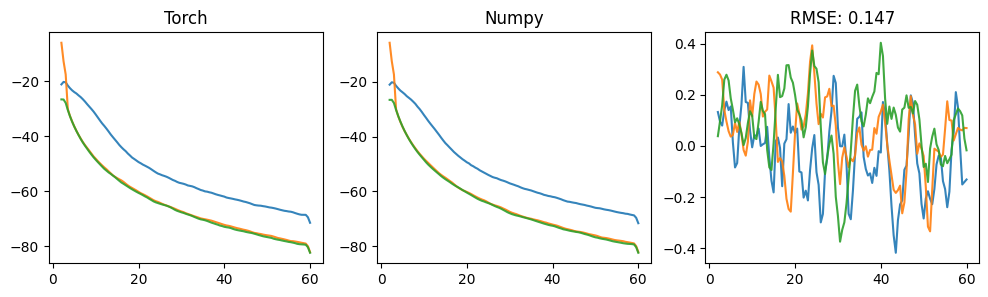

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for s in res_sgm_torch:
    axs[0].plot(fvec, s, alpha=0.9);
    axs[0].set_title('Torch')
for s in res_sgm_orig:
    axs[1].plot(fvec, s, alpha=0.9);
    axs[1].set_title('Numpy')
for s1,s2 in zip(res_sgm_torch, res_sgm_orig):
    axs[2].plot(fvec, s2-s1.numpy(), alpha=0.9);
    axs[2].set_title(f'RMSE: {mean_squared_error(res_sgm_orig, res_sgm_torch, squared=False):.3f}')

# Compare execution time

In [175]:
def SGM_torch_(params, fvec_torch):
    baby_brain = TorchBrain(params, fvec_torch)
    baby_brain.f()
    baby_brain.run_lpf()
    return baby_brain.get_sig_dB()

single_param = torch.Tensor(all_bounds[0][np.newaxis])
fvec_torch = torch.from_numpy(fvec)

In [176]:
execution_time = timeit.timeit(lambda: SGM_simulator(all_bounds[0], fvec), number=10)
print(f"SGM numpy execution time: {execution_time} seconds")

execution_time = timeit.timeit(lambda: SGM_torch_(single_param, fvec_torch), number=10)
print(f"SGM torch execution time: {execution_time} seconds")

SGM numpy execution time: 3.27405783300037 seconds
SGM torch execution time: 1.5917129999997996 seconds
